<a href="https://colab.research.google.com/github/faithrts/COMP-551/blob/Joey-added-experiments/A2_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [64]:
### importing libraries and setting the random seed

import numpy as np
import pandas as pd

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import re
import math
import bisect
from scipy.stats import zscore
from scipy.io import arff
from importlib import reload

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import load_svmlight_file
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as skl_train_test_split
from sklearn.metrics import mutual_info_score

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

# a folder to store the saved graphs
!mkdir images

mkdir: cannot create directory ‘images’: File exists


# Data Handling

## Importing

In [65]:
### importing the files from the web to google colab

# retrieving the IMDB data
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

# unzipping the tar.gz file into google colab for easy access
!tar -xf  'aclImdb_v1.tar.gz'

--2022-11-03 17:40:53--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  30.2MB/s    in 2.7s    

2022-11-03 17:40:56 (30.2 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



## Preprocessing

### Helper functions

In [66]:
def filter_svmlight(matrix, vocab):
  # boolean matrix for all values not equal to 0
  X_boolean = matrix != 0  

  # 1 X 1 matrix with the percentage of documents that includes each word (per column)
  X_doc_percentage = X_boolean.astype(int).sum(axis = 0) / matrix.shape[0]

  ''' finding the stopwords and rarewords '''

  # 1 X 1 boolean matrix indicates whether each column (word) is a stopword
  X_bool_stopwords = X_doc_percentage > 0.5

  # 1 X 1 boolean matrix indicates whether each column (word) is a rareword
  X_bool_rarewords = X_doc_percentage < 0.01

  # boolean list for whether each index (word) is not a stopword
  not_stopwords = [not word for word in X_bool_stopwords.tolist()[0]]

  # boolean list for whether each index (word) is not a rare word
  not_rarewords = [not word for word in X_bool_rarewords.tolist()[0]]

  ''' finding the column indices of words that are not stopwords or rare words '''

  not_stopword_indices = [index for index, x in enumerate(np.transpose(not_stopwords)) if x]
  not_rareword_indices = [index for index, x in enumerate(np.transpose(not_rarewords)) if x]

  # the intsersection of the two lists above are the indices of words that are neither
  # stopwords nor rare words
  not_stop_or_rare_indices = [index for index in not_stopword_indices if index in not_rareword_indices]

  ''' filtering for the words that are neither stopwords nor rare words '''

  # filters the original matrix
  X_filtered = matrix[:, not_stop_or_rare_indices]

  # filters the list of terms
  vocab_filtered = [vocab[index] for index in not_stop_or_rare_indices]

  return X_filtered, vocab_filtered

In [67]:
class LinearRegression:
  def __init__(self, add_bias = True):
    self.add_bias = add_bias

  def fit(self, x, y):
    # if the dimension of x is 1
    if x.ndim == 1:
      # adds an extra dimension 
      # e.g., [1, 2, 3] -> [[1], [2], [3]]
      x = x[:, None]

    # the number of instances
    N = x.shape[0]

    if self.add_bias:
      # adds bias by adding a constant feature of value 1
      # e.g., [[1], [2], [3]] -> [[1, 1], [2, 1], [3, 1]]
      x = np.column_stack([x, np.ones(N)])

    # w is the least square difference (w0 and w1)
    self.w = np.linalg.lstsq(x, y)[0]

    return self

  def predict(self, x):
    # the number of instances
    N = x.shape[0]

    if self.add_bias:
      # adds bias by adding a constant feature of value 1
      # e.g., [[1], [2], [3]] -> [[1, 1], [2, 1], [3, 1]]
      x = np.column_stack([x, np.ones(N)])

    # predict the y values where @ denotes matrix multiplication
    # y = Xw
    yh = x @ self.w

    return yh

In [68]:
def standardize_array(arr):
  # empty array to append the elements of the standardized array
  standardized_array = []

  # the mean and standard deviation of the input array
  mean_val = arr.mean()
  standard_dev = arr.std()

  # iterates through the input array
  for i in arr:
    # for each array element, calculates the standardized element
    # and appends it to the standardized array
    new_val = (i - mean_val) / standard_dev
    standardized_array.append(new_val)

  return standardized_array

In [69]:
def standardize_list(list):
  # empty array to append the elements of the standardized list
  standardized_list = []

  # the mean and standard deviation of the input list
  mean_val = sum(list) / len(list)
  standard_dev = np.std(list)

  # iterates through the input list
  for i in list:
    # for each list element, calculates the standardized element
    # and appends it to the standardized list
    new_val = (i - mean_val) / standard_dev
    standardized_list.append(new_val)

  return standardized_list

In [70]:
def compute_zscores(df):
  # assumes the input dataframe's last column is the labels
  y = df.iloc[:, -1]
  # standardizes the label columns
  y_stan = standardize_list(y.tolist())

  # the number of instances
  N = df.shape[0]

  # an empty array to which to append each column's z-scores
  z_scores = []

  # iterates through the non-label columns of the input dataframe
  for col in IMDB_train_df.iloc[:, :-1]:
    # standardizes the current column
    x_stan = standardize_list(df[col].tolist())

    # calculates the z-score of the current column and appends it
    # to the list of z-scores
    col_z_score = (np.transpose(x_stan) @ y_stan) / math.sqrt(N)
    z_scores.append(col_z_score)

  return z_scores

In [71]:
# custom pre-processor to remove digits and punctuation for CountVectorizer
def keep_only_letters_preprocessor(text):
  # converts text to lowercase
  text = text.lower()
  # replaces digits and selected punctuation with empty string
  text = re.sub('([0-9,.!?;:_])', '', text)
  return text

In [72]:
def zscore_horizontal_bar_plot(zscores, features):
  width = 8 * (len(features) / 20)
  height = 6 * (len(features) / 20)

  plt.figure(figsize=(width, height))

  plt.barh(features, zscores)
  plt.title('Top 20 Features')
  plt.ylabel('Features')
  plt.xlabel('Z-scores')
  plt.savefig("images/zscore_barplot.png", bbox_inches = 'tight', dpi=300)
  plt.show()

In [73]:
# assumes the last column of the dataframe is the labels
def x_y_from_df(df):
  x = df.iloc[:, :-1].to_numpy()
  y = df.iloc[:, -1].to_numpy()

  return x, y

In [74]:
# standardizes columns in input dataframe df;
# assumes last column is the target labels
def standardize_df(df):
  standardized_df = df.copy()

  # iterates through each column, excluding the last column
  for col in standardized_df.iloc[:, :-1]:

    # calculates mean value and standard deviation of column
    mean_val = standardized_df[col].mean()
    standard_dev = standardized_df[col].std()

    # standardizes the values in the current column
    standardized_df[col] = (standardized_df[col] - mean_val) / standard_dev

  return standardized_df

#### For mutual information

In [75]:
def MI_helper(df, num):

  copy_df = df.copy()

  # setting all label values not equal to num to -1 (originally I set
  # them immediately to 0, but then this didn't work when num == 0)
  copy_df.loc[copy_df['LABEL'] != num, 'LABEL'] = -1

  # setting all label values equal to num to 1
  copy_df.loc[copy_df['LABEL'] == num, 'LABEL'] = 1

  # setting all label values not equal to num to 0 for MI calculations
  copy_df.loc[copy_df['LABEL'] == -1, 'LABEL'] = 0

  # retrieving the label column
  labels = copy_df.iloc[:, -1].to_numpy()

  MI_scores = []

  # encapsulating gary's code to do MI calculations
  for col in df.iloc[:, :-1]:
    col_as_list = df[col].tolist()
    MI_scores.append(make_MI_scores(labels, col_as_list))

  best_features = show_MI_scores25(MI_scores).keys()

  return best_features

In [76]:
# computes the MI scores
def make_MI_scores(Labels_true, Labels_pred):
  mi_scores = mutual_info_score(Labels_true, Labels_pred)
  return mi_scores

In [77]:
# displays and returns the best 25 MI scores and features for a class
def show_MI_scores25(mi_scores):
  show_scores = pd.Series(mi_scores)
  show_scores = show_scores.sort_values(ascending = False)
  show_scores = show_scores[0:25] # shows the first 25 features with the highest MI scores
  return show_scores

In [78]:
# gets the union of the 25 MI Scores and best features for all 4 classes
def top25_union(score1, score2, score3, score4):
  union = []
  for i in range(25):
    union.append(score1[i])
    union.append(score2[i])
    union.append(score3[i])
    union.append(score4[i])
  union = pd.unique(union)
  return union

In [79]:
def union(list_of_lists):
  union = []

  for cur_list in list_of_lists:
    union.extend(cur_list)

  union = pd.unique(union)
  return union

### Loading and cleaning IMDB data

In [80]:
### loading the svm files into sparse matrices

# X is the sparse matrix, y are the labels
X_IMDB_train, y_IMDB_train = load_svmlight_file('aclImdb/train/labeledBow.feat', dtype=int)

# X is the sparse matrix, y are the labels
X_IMDB_test, y_IMDB_test = load_svmlight_file('aclImdb/test/labeledBow.feat', dtype=int)

# saving a list of the terms/vocab
IMDB_vocab = [line.rstrip() for line in open('aclImdb/imdb.vocab')]

In [81]:
### filtering the IMDB matrices to remove stop words and rare words

# uses helper function to return filtered matrices and list of words (vocab)
X_IMDB_train_filtered, IMDB_train_vocab_filtered = filter_svmlight(X_IMDB_train, IMDB_vocab)
X_IMDB_test_filtered, IMDB_test_vocab_filtered = filter_svmlight(X_IMDB_test, IMDB_vocab)

In [82]:
### creating dataframes out of the words that are neither stopwords nor rare words

# creates dataframes
IMDB_train_df = pd.DataFrame(X_IMDB_train_filtered.toarray(), columns = IMDB_train_vocab_filtered)
IMDB_test_df = pd.DataFrame(X_IMDB_test_filtered.toarray(), columns = IMDB_test_vocab_filtered)

# adds the target labels as a column
IMDB_train_df['LABEL'] = y_IMDB_train.astype(int)
IMDB_test_df['LABEL'] = y_IMDB_test.astype(int)

# dataframes that preserve the movie review values
IMDB_train_zscore_df = IMDB_train_df.copy()
IMDB_test_zscore_df = IMDB_test_df.copy()

# dataframes that label negative reviews as 0 and positive reviews as 1
IMDB_train_df['LABEL'] = IMDB_train_df['LABEL'].replace({0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:1, 10:1})
IMDB_test_df['LABEL'] = IMDB_test_df['LABEL'].replace({0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:1, 10:1})

In [83]:
IMDB_train_df

,he,his,!,by,an,who,they,from,so,like,...,portray,length,discovered,aware,continues,below,opens,essentially,received,LABEL
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,1,0,3,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,1,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,5,0,9,3,1,7,3,2,1,0,...,0,0,0,0,0,1,0,0,0,0
24996,2,2,1,0,0,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
24997,0,2,0,2,1,2,3,1,0,3,...,0,0,0,0,0,0,1,0,0,0
24998,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
IMDB_test_df

,he,his,!,by,an,who,they,from,so,like,...,pair,thomas,protagonist,tape,range,generation,ryan,post,provided,LABEL
0,1,0,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,3,1,1,2,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,0,0,0,5,6,2,...,0,0,0,0,0,0,0,0,0,1
4,0,2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,4,3,0,3,1,2,0,2,0,3,...,0,0,0,0,0,0,0,0,0,0
24996,1,1,0,2,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,3,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,2,0,2,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Loading and cleaning Twenty News Groups data

In [85]:
### selecting 4 categories and extracting the data from sklearn

fav_four = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.politics.guns']

# 20 news groups training
twenty_train = fetch_20newsgroups(subset='train', categories=fav_four, remove=(['headers', 'footers', 'quotes']))
# 20 news groups testing
twenty_test = fetch_20newsgroups(subset='test', categories=fav_four, remove=(['headers', 'footers', 'quotes']))

In [86]:
### transforming the data into vectors

# creates new CountVectorizer objects to turn each instance into a vector of word counts
count_vect = CountVectorizer(max_df=0.5, min_df=0.01, preprocessor = keep_only_letters_preprocessor)
count_vect_test = CountVectorizer(preprocessor = keep_only_letters_preprocessor)

# builds a dictionary of features and transforms documents to feature
# vectors where each index represents the occurrence of a specific word
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_test_counts = count_vect_test.fit_transform(twenty_test.data)

# retrieving the names of the features
train_feature_names = count_vect.get_feature_names_out()
test_feature_names = count_vect_test.get_feature_names_out()

# creating dataframes in which each row represents a document and each column
# a word
twenty_train_df = pd.DataFrame(X_train_counts.toarray(), columns = train_feature_names)
twenty_test_df = pd.DataFrame(X_test_counts.toarray(), columns = test_feature_names)

In [87]:
### adding label (target) column

twenty_train_df['LABEL'] = twenty_train.target
twenty_test_df['LABEL'] = twenty_test.target

# one-hot encoding
#twenty_train_df['LABEL'] = twenty_train_df['LABEL'].replace({0:'[1,0,0,0]', 1:'[0,1,0,0]', 2:'[0,0,1,0]', 3:'[0,0,0,1]'})
#twenty_test_df['LABEL'] = twenty_test_df['LABEL'].replace({0:'[1,0,0,0]', 1:'[0,1,0,0]', 2:'[0,0,1,0]', 3:'[0,0,0,1]'})

In [88]:
twenty_train_df

,ability,able,about,above,accept,acceptable,accepted,access,according,account,...,year,years,yes,yesterday,yet,york,you,your,yourself,LABEL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,8,3,0,3
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2200,0,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
2201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,0,0,0


In [89]:
# it's okay that this df has some weird words as they are likely to only appear
# in a few documents, meaning that feature extraction will likely discount them
# when we filter the features for the most significant ones
twenty_test_df

,aa,aacs,aah,aam,aaoeppaaogovau,aap,aaplay,aarnet,aaroundpluto,aatdb,...,zugcsmilumichedu,zur,zurich,zvezdny,zvi,zwork,zyda,zyxel,zz,LABEL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1464,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### Determining important features for IMDB data


In [90]:
### computing z-score of each feature

# returns a list of z-scores where the value at index i is the z-score
# of the word at column i in the dataframe
zscores = compute_zscores(IMDB_train_df)

# computes the absolute values of each z-score
abs_zscores = list(map(abs, zscores))

In [91]:
### determining the 10 most positive and 10 most negative z-scores + associated words

# the indices of the words with the 10 most positive z-scores
pos_10_zscore_inds = np.argsort(np.array(zscores))[::-1][0:10]
# the words with the 10 most positive z-scores
pos_10_words = [IMDB_train_vocab_filtered[i] for i in pos_10_zscore_inds]

# the indices of the words with the 10 most negative z-scores
neg_10_zscore_inds = np.argsort(np.array(zscores))[0:10]
# the words with the 10 most negative z-scores
neg_10_words = [IMDB_train_vocab_filtered[i] for i in neg_10_zscore_inds]

# collects the above two groups together
pos_neg_zscores = np.concatenate((np.sort(np.array(zscores))[::-1][0:10], np.sort(np.array(zscores))[0:10])).tolist()
pos_neg_20_words = np.concatenate((pos_10_words, neg_10_words)).tolist()

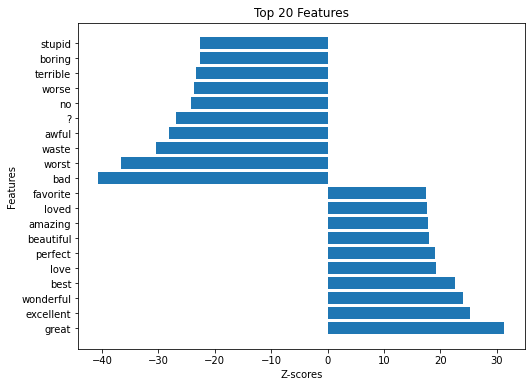

In [92]:
### graphing the 10 most positive and 10 most negative z-scores + associated words

zscore_horizontal_bar_plot(pos_neg_zscores, pos_neg_20_words)

In [93]:
### filtering the IMDB dataframes to only include words from the top 20 found

# making copies of the original dataframe
IMDB_train_20_filtered_df = IMDB_train_df.copy()
IMDB_test_20_filtered_df = IMDB_test_df.copy()

# making lists of the words to use as column names
train_20_new_words = pos_neg_20_words + ['LABEL']
test_20_new_words = [word for word in train_20_new_words if word in IMDB_test_df.columns.tolist()]

# filtering the IMDB dataframe to only include words from the top 100 found
IMDB_train_20_filtered_df = IMDB_train_df[train_20_new_words]
IMDB_test_20_filtered_df = IMDB_test_df[test_20_new_words]

# removing rows with all zeros from the dataframes
IMDB_train_20_filtered_df = IMDB_train_20_filtered_df.loc[(IMDB_train_20_filtered_df != 0).any(axis = 1)]
IMDB_test_20_filtered_df = IMDB_test_20_filtered_df.loc[(IMDB_test_20_filtered_df != 0).any(axis = 1)]

In [94]:
IMDB_train_20_filtered_df

,great,excellent,wonderful,best,love,perfect,beautiful,amazing,loved,favorite,...,worst,waste,awful,?,no,worse,terrible,boring,stupid,LABEL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,0,1
4,1,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,3,0,0,0,0,0,...,0,0,0,5,0,1,0,0,0,0
24996,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
24998,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [95]:
IMDB_test_20_filtered_df

,great,excellent,wonderful,best,love,perfect,beautiful,amazing,loved,favorite,...,worst,waste,awful,?,no,worse,terrible,boring,stupid,LABEL
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,1,1,0,0,2,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,2,0,0,0,0,0,0
24996,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
24997,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,0,0,0


In [96]:
### determining the 100 most "important" words based on their z-scores

# the z-scores of the words with the greatest absolute z-scores
top_100_zscores = np.sort(np.array(abs_zscores))[::-1][0:100]

# the indices of the words with the greatest absolute z-scores
top_100_zscores_inds = np.argsort(np.array(abs_zscores))[::-1][0:100]

# the words with the top 100 absolute z-scores
top_100_words = [IMDB_train_vocab_filtered[i] for i in top_100_zscores_inds]

In [97]:
### analyzing the top 100 words

top_100_words

['bad',
 'worst',
 'great',
 'waste',
 'awful',
 '?',
 'excellent',
 'no',
 'wonderful',
 'worse',
 'terrible',
 'boring',
 'best',
 'stupid',
 'nothing',
 'horrible',
 'poor',
 'minutes',
 'crap',
 'even',
 'just',
 'supposed',
 'love',
 'perfect',
 'poorly',
 'acting',
 'ridiculous',
 'plot',
 'beautiful',
 'lame',
 'amazing',
 'script',
 'loved',
 'favorite',
 'pointless',
 'avoid',
 "don't",
 'why',
 'superb',
 'highly',
 'annoying',
 'brilliant',
 'also',
 'mess',
 'dull',
 'wasted',
 'money',
 'very',
 'any',
 'fantastic',
 'badly',
 'life',
 'oh',
 'thing',
 'both',
 'well',
 'laughable',
 'today',
 'unless',
 'least',
 'pathetic',
 'there',
 'instead',
 'performance',
 'cheap',
 'redeeming',
 'his',
 'always',
 'if',
 'performances',
 "couldn't",
 'beautifully',
 'reason',
 'or',
 'enjoyed',
 'save',
 'make',
 'could',
 'fails',
 'touching',
 'wonderfully',
 'anything',
 'garbage',
 'young',
 'unfortunately',
 'world',
 'years',
 'only',
 'predictable',
 'excuse',
 'powerful',


In [98]:
### filtering the IMDB dataframes to only include words from the top 100 found

# making copies of the original dataframe
IMDB_train_filtered_df = IMDB_train_df.copy()
IMDB_test_filtered_df = IMDB_test_df.copy()

# making lists of the words to use as column names
train_new_words = top_100_words + ['LABEL']
test_new_words = [word for word in train_new_words if word in IMDB_test_df.columns.tolist()]

# filtering the IMDB dataframe to only include words from the top 100 found
IMDB_train_filtered_df = IMDB_train_df[train_new_words]
IMDB_test_filtered_df = IMDB_test_df[test_new_words]

# removing rows with all zeros from the dataframes
IMDB_train_filtered_df = IMDB_train_filtered_df.loc[(IMDB_train_filtered_df != 0).any(axis = 1)]
IMDB_test_filtered_df = IMDB_test_filtered_df.loc[(IMDB_test_filtered_df != 0).any(axis = 1)]

In [99]:
IMDB_train_filtered_df

,bad,worst,great,waste,awful,?,excellent,no,wonderful,worse,...,didn't,perfectly,decent,outstanding,dumb,sorry,job,guess,terrific,LABEL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3,0,0,0,0,5,0,0,0,1,...,1,0,0,0,0,2,0,0,0,0
24996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
IMDB_test_filtered_df

,bad,worst,great,waste,awful,?,excellent,no,wonderful,worse,...,didn't,perfectly,decent,outstanding,dumb,sorry,job,guess,terrific,LABEL
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,2,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
2,0,0,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
3,2,0,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2,0,0,1,0,2,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
24996,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,1,0,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### Determining important features for Twenty News Groups data

In [101]:
### finding the union of the most significant features for each class using MI

best_features = []

# iterates from 0 to the number of categories - 1
for category in range(len(fav_four)):

  # calculates the MI scores for the current category
  MI_scores = MI_helper(twenty_train_df, category)

  # adds the best features for this category to the union of all best features
  best_features = union([best_features, MI_scores])

MI_words = [train_feature_names[i] for i in best_features]

# sorting the words alphabetically
MI_words.sort()

In [102]:
### filtering the twenty dataframes to only include words from the top 100 found

# making copies of the original dataframe
twenty_train_filtered_df = twenty_train_df.copy()
twenty_test_filtered_df = twenty_test_df.copy()

# making lists of the words to use as column names
train_new_words = MI_words + ['LABEL']
test_new_words = [word for word in train_new_words if word in twenty_test_df.columns.tolist()]

# filtering the twenty dataframe to only include words from the top 100 found
twenty_train_filtered_df = twenty_train_df[train_new_words]
twenty_test_filtered_df = twenty_test_df[test_new_words]

# removing rows with all zeros from the dataframes
twenty_train_filtered_df = twenty_train_filtered_df.loc[(twenty_train_filtered_df != 0).any(axis = 1)]
twenty_test_filtered_df = twenty_test_filtered_df.loc[(twenty_test_filtered_df != 0).any(axis = 1)]

In [183]:
twenty_train_filtered_df.loc[:,["advance","LABEL"]]

,advance,LABEL
0,0,0
1,0,3
2,0,3
3,0,1
4,0,2
...,...,...
2198,0,2
2199,0,1
2200,0,0
2201,0,0


In [104]:
twenty_test_filtered_df

,advance,amendment,argument,as,assault,atheism,atheist,atheists,batf,belief,...,vga,waco,was,weapon,weapons,were,who,windows,you,LABEL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,0,0,0,2,0,0,2,4,0,0,...,0,0,1,0,0,0,2,0,5,0
2,1,0,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
1462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1464,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


### Extracting training and testing data for experiments

In [105]:
### for IMDB

''' top 100 words '''
x_train_IMDB, y_train_IMDB = x_y_from_df(IMDB_train_filtered_df)
x_test_IMDB, y_test_IMDB = x_y_from_df(IMDB_test_filtered_df)

''' top 100 words shuffled instance order '''
# shuffling the rows in the dataframes
IMDB_train_shuf_df = IMDB_train_filtered_df.copy().sample(frac = 1, random_state = 1)
IMDB_test_shuf_df = IMDB_test_filtered_df.copy().sample(frac = 1, random_state = 1)

x_train_shuf_IMDB, y_train_shuf_IMDB = x_y_from_df(IMDB_train_shuf_df)

''' top 20 words '''
x_train_20_IMDB, y_train_20_IMDB = x_y_from_df(IMDB_train_20_filtered_df)
x_test_20_IMDB, y_test_20_IMDB = x_y_from_df(IMDB_test_20_filtered_df)

In [186]:
### for twenty news groups

''' union of MI words '''
x_train_twenty, y_train_twenty_temp = x_y_from_df(twenty_train_filtered_df)
x_test_twenty, y_test_twenty_temp = x_y_from_df(twenty_test_filtered_df)

y_train_twenty = []
y_test_twenty = []

# one-hot encoding
for i in y_train_twenty_temp:
  cur_train = [0, 0, 0, 0]
  cur_train[i] = 1
  y_train_twenty.append(cur_train)

for i in y_test_twenty_temp:
  cur_test = [0, 0, 0, 0]
  cur_test[i] = 1
  y_test_twenty.append(cur_test)

y_train_twenty = np.array(y_train_twenty)
y_test_twenty = np.array(y_test_twenty)

''' standardized data '''
twenty_train_stan_df = standardize_df(twenty_train_filtered_df)
twenty_test_stan_df = standardize_df(twenty_test_filtered_df)

x_train_stan_twenty, y_train_stan_twenty_temp = x_y_from_df(twenty_train_stan_df)
x_test_stan_twenty, y_test_stan_twenty_temp = x_y_from_df(twenty_test_stan_df)

# Implementing models

## Helper functions

In [107]:
### cross-entropy cost function
def cross_entropy(x, w, y):
  a = np.dot(x, w)
  J = np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))
  return J

In [108]:
### logistic function calculation
def logistic(x, w):
  a = np.dot(x, w)
  return 1./ (1+(np.exp(-a)))

In [109]:
### gradient calculation
def gradient(x, w, y):
  N,D = x.shape
  y_hat = logistic(x,w)

  # divide by N because cost is mean over N points otherwise we would get
  # different results for larger number of N
  return np.dot(x.T, (y_hat - y))/N

## Logistic regression

In [110]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
      self.add_bias = add_bias
      self.learning_rate = learning_rate

      # to get the tolerance for the norm of gradients
      self.epsilon = epsilon

      # maximum number of iteration of gradient descent
      self.max_iters = max_iters                    
        
      self.verbose = verbose
    
    def fit(self, x, y, silent = True):
      
      # setup
      if x.ndim == 1:
        x = x[:, None]
      if self.add_bias:
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])

      N,D = x.shape

      # randomly initialize regression coefficients wd  
      self.w = np.random.rand(D) 
      old_Cost = cross_entropy(x, self.w, y)
      
      t = 0

      while t< self.max_iters:
        # if t%100==0: print(t)
      
        # calculate new w
        self.w = self.w - self.learning_rate * gradient(x, self.w, y) 
        
        # calculate new cost
        new_Cost = cross_entropy(x, self.w, y)

        # stopping criteria 
        if(np.linalg.norm(new_Cost-old_Cost) < self.epsilon):
          break

        t += 1

      if not silent:
        print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(gradient(x, self.w, y))}')
        print(f'the weight(s) found: {self.w}')

      return self

    def predict(self, x):

      # applies to the case where x is a single row insted of in column form
      if x.ndim == 1:
        x = x[:, None]

      # need to add a column of 1's if we have a bias term (w0)
      if self.add_bias:
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])
      
      return logistic(x, self.w)

## Multi-class regression classifier

In [124]:
class MultinomialLogistic:
  def __init__(self, nFeatures, nClasses):
    self.W = np.random.rand(nFeatures, nClasses)

  '''
  # calculating Y_hat with shape Cx1
  def softMaxPredict(self, x):
    a = np.matmul(x, self.W)

    # if X_n has shape 1xD and w has shape DxC, then Y_hat will have shape 1XC
    return (np.exp(a)/np.sum(a, axis=1)).reshape(x.shape[0], 1)
  '''

  # calculating Y_hat with shape Cx1
  def predict(self, x):
    y_pred = np.exp(np.matmul(x, self.W))
    N,D = x.shape
    print(y_pred)

    # if X_n has shape 1xD and w has shape DxC, then Y_hat will have shape 1XC
    return y_pred / y_pred.sum(axis=1, keepdims = True)

  # calculating J(w)
  def multiCost(self, x, y):
    return - np.sum(np.dot(y, np.log(self.predict(x))))

  def multiGrad(self, x, y):
    return np.dot(x.transpose(), self.predict(x) - y)

  def fit(self, x, y, lr=0.005, niter=100):
    for i in range(niter):
      self.W = self.W - lr * self.multiGrad(x,y)
    return self

# Running experiments

### Helper functions

In [112]:
def knn_compare_AUROC(x_train, y_train, x_test, y_test, title = 0):

  ''' using logistic regression '''
  biased_log_reg = LogisticRegression(max_iters=1e4)
  y_lr_test_prob = biased_log_reg.fit(x_train, y_train, silent = True).predict(x_test)
  lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_lr_test_prob)
  lr_roc_auc = roc_auc_score(y_test, y_lr_test_prob)

  ''' using KNN '''
  # creates a KNN object (OOP)
  knn = KNeighborsClassifier()
  #x_train =x_train.reshape(-1, 1)
  #y_train =y_train.reshape(-1, 1)
  #x_test =x_test.reshape(-1, 1)
  knn.fit(x_train, y_train)
  y_knn_test_prob = knn.predict_proba(x_test)[:,1]
  knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, y_knn_test_prob)
  knn_roc_auc = roc_auc_score(y_test, y_knn_test_prob)

  if title != 0:
    
    #print(lr_thresholds)
    plt.clf()
    plt.plot(lr_fpr, lr_tpr, "r-", lw=2, label="Linear regression AUROC = %0.2f"%lr_roc_auc)
    plt.plot(knn_fpr, knn_tpr, "b-", lw=2, label="KNN AUROC = %0.2f"%knn_roc_auc)

    # plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc = "best")
    plt.savefig("images/roc_curve.png", bbox_inches = 'tight', dpi=300)

  return lr_roc_auc, knn_roc_auc

In [113]:
def coefficients_horizontal_bar_plot(coefficients, features):
  width = 8 * (len(features) / 20)
  height = 6 * (len(features) / 20)

  plt.figure(figsize=(width, height))

  plt.barh(features, coefficients)
  plt.title('Top 20 Features')
  plt.ylabel('Features')
  plt.xlabel('Coefficients')
  plt.savefig("images/coefficients_barplot.png", bbox_inches = 'tight', dpi=300)
  plt.show()

In [114]:
### accuracy-evaluating function
def evaluate_acc(true_labels, target_labels):

  # the number of labels
  label_count = true_labels.shape[0]

  # the accuracy is the number of correctly labelled instances
  # divided by the total amount
  accuracy = np.sum(target_labels == true_labels)/label_count

  return accuracy

In [115]:
### running logistic regreesion on IMDB data (top 100 words)
def evaluate_log_acc(x_train, y_train, x_test, y_test):
  # makes a logistic regression model and fits it on the training data
  log_reg = LogisticRegression(max_iters=1e4).fit(x_train, y_train, silent = True)

  # uses the model to predict classifications on both the training
  # and testing data
  y_train_prob = log_reg.predict(x_train)
  y_test_prob = log_reg.predict(x_test)

  # threshold probabilities
  y_train_pred = (y_train_prob > 0.5).astype(int)
  y_test_pred = (y_test_prob > 0.5).astype(int)

  # accuracy = correctly classified / total classified
  train_acc = evaluate_acc(y_train, y_train_pred)
  test_acc = evaluate_acc(y_test, y_test_pred)

  print("The accuracy of the model on the training data: " + str(round((train_acc * 100), 2)) + "%")
  print("The accuracy of the model on the testing data: " + str(round((test_acc * 100), 2)) + "%")

  return train_acc, test_acc

In [116]:
def evaluate_mult_acc(x_train, y_train, x_test, y_test):
  D = x_train.shape[1]
  C = y_train.shape[1]
  multi_reg = MultinomialLogistic(D, C).fit(x_train, y_train, lr = 0.001)

  # the following returns the probability of each class
  y_train_prob = multi_reg.predict(x_train)
  y_test_prob = multi_reg.predict(x_test)

  # calculating the predictions
  y_train_pred = y_train_prob.argmax(axis = 1)
  y_test_pred = y_test_prob.argmax(axis = 1)

  # accuracy = correctly classified / total classified
  train_acc = evaluate_acc(y_train, y_train_pred)
  test_acc = evaluate_acc(y_test, y_test_pred)

  print("The accuracy of the model on the training data: " + str(round((train_acc * 100), 2)) + "%")
  print("The accuracy of the model on the testing data: " + str(round((test_acc * 100), 2)) + "%")

  return train_acc, test_acc

In [117]:
def mult_knn_compare_AUROC(x_train, y_train, x_test, y_test, percentages):
  lr_AUROCs = []
  knn_AUROCs = []

  perc_1 = len(x_train) / 100

  # assumes percentages are integers up to 100
  for percentage in percentages:
    cur_perc = int(perc_1 * percentage)
    x_train_temp = x_train[0 : cur_perc]
    y_train_temp = y_train[0 : cur_perc]

    lr_roc_auc, knn_roc_auc = knn_compare_AUROC(x_train_temp, y_train_temp, x_test, y_test)

    lr_AUROCs.append(lr_roc_auc)
    knn_AUROCs.append(knn_roc_auc)

  return lr_AUROCs, knn_AUROCs

In [118]:
def AUROC_bar_plot(lr_auroc, knn_auroc, percentages):
  #width = 8 * (len(percentages) / 20)
  #height = 6 * (len(percentages) / 20)

  #plt.figure(figsize=(width, height))

  N = np.arange(len(percentages))

  width = 0.4

  plt.bar(N, lr_auroc, width = width, color="#8ad07c", label = 'Logistic Regression')
  plt.bar(N + width, knn_auroc, width = width, color='#AFB4FF', label = 'KNN')

  plt.ylabel('AUROC')
  plt.xlabel('% of data used for training')
  plt.title('Logistic Regression and KNN AUROC on Different Data %s')

  plt.xticks(N + width/2, percentages)
  plt.legend()
  plt.savefig("images/auroc_percentages_barplot.png", bbox_inches = 'tight', dpi=300)
  plt.show()

## Logistic regression experiments

### Baseline accuracy tests

In [119]:
### running logistic regreesion on IMDB data (top 100 words)

train_acc, test_acc = evaluate_log_acc(x_train_IMDB, y_train_IMDB, x_test_IMDB, y_test_IMDB)

The accuracy of the model on the training data: 83.25%
The accuracy of the model on the testing data: 83.08%


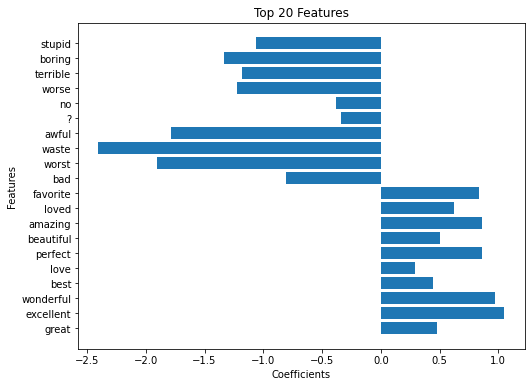

In [120]:
### running logistic regreesion on IMDB data (top 20 words)

# creates a logistic regression object
log_reg = LogisticRegression(max_iters=1e4).fit(x_train_20_IMDB, y_train_20_IMDB, silent = True)

# saves the coefficients outputted by logsitic regression
log_reg_20_weights = log_reg.fit(x_train_20_IMDB, y_train_20_IMDB, silent = True).w

# plots the top 20 features with their coefficients on the x-axis
coefficients_horizontal_bar_plot(log_reg_20_weights[0:-1], pos_neg_20_words)

### Area Under ROC Curve

In [121]:
### comparing the AUROC of KNN vs biased logistic regression

lr_100_auroc, knn_100_auroc = knn_compare_AUROC(x_train_IMDB, y_train_IMDB, x_test_IMDB, y_test_IMDB, "ROC to predict IMDB")

KeyboardInterrupt: ignored

### Comparing AUROC on different percentages of training data

In [ ]:
### comparing AUROC of KNN vs biased logistic ression on different train data %s

lr_AUROCs, knn_AUROCs = mult_knn_compare_AUROC(x_train_shuf_IMDB, y_train_shuf_IMDB, x_test_IMDB, y_test_IMDB, [20, 40, 60, 80])
AUROC_bar_plot(lr_AUROCs, knn_AUROCs, [20, 40, 60, 80])

## Multi-class regression experiments

### Baseline accuracy tests


In [122]:
y_train_twenty

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

In [125]:
### running multiclass regression on twenty news group data (old)

train_acc, test_acc = evaluate_mult_acc(x_train_twenty, y_train_twenty, x_test_twenty, y_test_twenty)

[[2.54142658e+02 4.75338384e+01 3.06701869e+01 6.11508338e+02]
 [7.41039251e+04 1.96144339e+04 3.46153311e+04 1.36879134e+05]
 [1.06116429e+02 8.47166634e+01 1.38548336e+01 1.67307122e+02]
 ...
 [2.80073399e+01 3.60431052e+01 5.21818029e+01 4.76792040e+02]
 [5.27244421e+07 8.44592215e+08 1.25517009e+06 2.17984502e+07]
 [1.25414842e+01 4.60763757e+00 9.76283497e+00 3.71408840e+01]]
[[2.02492399e+06 3.88145378e+07 1.67864438e-02 1.71726538e-04]
 [3.10403637e+16 1.84125112e+18 1.39201509e-06 8.65643275e-11]
 [6.02951164e+06 2.80178011e+07 2.22319712e-02 5.54846759e-06]
 ...
 [4.69681263e+06 3.61671909e+05 8.71526070e-03 1.69646046e-03]
 [4.08421580e+21 2.71055033e+20 3.16179515e-05 3.48086662e-08]
 [1.89528009e+01 3.61031996e+01 2.74186584e+00 1.11683788e+01]]
[[           nan            nan 1.61044089e-02 2.86956065e+07]
 [           nan            nan 1.34852137e-06 3.38091740e+21]
 [           nan            nan 2.15465884e-02 4.32750564e+04]
 ...
 [           nan            nan 8.5124

In [126]:
### running multiclass regression on twenty news group data (new)

train_acc, test_acc = evaluate_mult_acc(x_train_stan_twenty, y_train_twenty, x_test_stan_twenty, y_test_twenty)

[[3.89151146e-02 3.50283518e-02 2.71580178e-01 2.08958589e-01]
 [2.83710509e-02 4.26551198e-01 2.86902153e-01 1.92881555e-01]
 [7.48009237e-02 9.26612375e-03 4.91847566e-02 6.92261324e-02]
 ...
 [1.93114046e-02 8.63919464e-02 3.83999147e-02 1.13721493e-01]
 [6.85074871e+07 4.17477847e+02 9.09862853e+03 1.01898147e+03]
 [2.96024993e+00 1.16622627e-01 1.48129251e+01 1.01984364e-01]]
[[7.84157837e-01 4.89278921e-02 6.30575953e-02 3.19741430e-02]
 [1.04412177e-02 1.47412697e+01 2.89026428e-01 1.50538469e-02]
 [6.19655896e-02 5.90164820e-02 2.46878397e-02 2.61395833e-02]
 ...
 [3.02517482e-01 2.20773376e-02 2.17597541e-02 5.01312778e-02]
 [3.11539279e+12 1.76350044e+00 1.02973931e+06 4.68703311e-02]
 [3.24448081e-01 5.28114029e-01 7.76840928e-04 3.91814590e+03]]
[[1.36536130e+00 1.48800596e-02 7.25692850e-02 5.24676010e-02]
 [1.62129638e-02 6.50361188e+00 3.27216194e-01 1.94097202e-02]
 [1.06684215e-01 1.78542472e-02 2.32899056e-02 5.31981114e-02]
 ...
 [6.69104430e-01 2.94363963e-03 5.2346

In [ ]:
train_acc, test_acc = evaluate_mult_acc(x_train_stan_twenty, y_train_twenty, x_test_stan_twenty, y_test_twenty)

Multiclass using colab code

In [221]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        #print(np.matmul(X, self.W))
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        N,C = X.shape
        return np.matmul(X.transpose(), self.predict(X) - y)/N

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            #print(self.W)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


In [227]:
def evaluate_mult_acc2(x_train, y_train, x_test, y_test, niter):
  D = x_train.shape[1]
  C = y_train.shape[1]
  multi_reg = Multinomial_logistic(D, C)
  A,_ = multi_reg.fit(x_train, y_train, lr = 0.001, niter = niter)

  # the following returns the probability of each class
  y_train_prob = multi_reg.predict(x_train)
  y_test_prob = multi_reg.predict(x_test)

  # calculating the predictions
  y_train_pred = y_train_prob.argmax(axis = 1)
  y_test_pred = y_test_prob.argmax(axis = 1)

  # accuracy = correctly classified / total classified
  train_acc = evaluate_acc(y_train.argmax(axis = 1), y_train_pred)
  test_acc = evaluate_acc(y_test.argmax(axis = 1), y_test_pred)

  print("The accuracy of the model on the training data: " + str(round((train_acc * 100), 2)) + "%")
  print("The accuracy of the model on the testing data: " + str(round((test_acc * 100), 2)) + "%")

  print(np.bincount(y_train.argmax(axis=1)))

  print(np.bincount(y_test_pred))
  print(np.bincount(y_test.argmax(axis = 1)))
  #print(y_test[:,3])
  plt.plot(range(A.shape[0]), A)
  return train_acc, test_acc

In [228]:
train_acc, test_acc = evaluate_mult_acc2(x_train_stan_twenty, y_train_twenty, x_test_stan_twenty, y_test_twenty, 1000)

Streaming output truncated to the last 5000 lines.
 [ 0.38959688  0.65888712  0.0881563   0.16307356]
 [ 0.66240744  0.32544639  0.81489516  0.65785319]
 [ 0.9707849   0.46620333  0.08571689  0.41418242]
 [ 0.12827813  0.14220817  0.04164775  0.50798574]
 [ 0.72578965  0.13898966  0.48387462  0.99383345]
 [ 0.19188828  0.58424949  0.16736472  0.67305588]
 [ 0.97144685  0.9886421   0.39189987  0.70046226]
 [ 0.6613204   0.93388742  0.28331073  0.3003264 ]
 [ 0.79360202  0.52668998  0.88036231  0.58468588]
 [ 0.17968327  0.41782315  0.78730277  0.77544171]
 [ 0.04706797  0.760964    0.16716203  0.51821721]
 [ 0.82654274  0.80468208  0.36587724  0.47920635]
 [ 0.76724951  0.69327766  0.54487798  0.90330844]
 [ 0.56843078  0.16927013  0.8715306   0.68073949]
 [ 0.41079213  0.48726438  0.94755385  0.8754594 ]]
iter 482: 4915.971
[[ 0.81730023  0.68416038  0.14575926  0.86833569]
 [ 0.29665277  0.13576563  0.93831051  0.18847495]
 [ 0.55676435  0.45789432  0.27848343  0.71796807]
 [ 0.707017

KeyboardInterrupt: ignored

(2169, 88)